In [1]:
import os 

# move to project root
while True:
    if os.getcwd().split("/")[-1] == "qa_ai":
        break
    else:
        os.chdir("..")

print(os.getcwd())

/home/ra/Codes/qa_ai


In [2]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from src.compute_and_plot_abroca import compute_abroca

In [3]:
# darkgrid, whitegrid, dark, white, ticks
sns.set(style="ticks", context="paper")
plt.style.use("dark_background")

# Some Utils

In [4]:
def compute_accuracy(confusion_matrix):
    """
    Function to compute accuracy from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns accuracy
    """
    return (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)

In [5]:
def compute_true_positive_rate(confusion_matrix):
    """
    Function to compute true positive rate from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns true positive rate
    """
    return confusion_matrix[1, 1] / np.sum(confusion_matrix[1, :])

In [6]:
def compute_true_negative_rate(confusion_matrix):
    """
    Function to compute true negative rate from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns true negative rate
    """
    return confusion_matrix[0, 0] / np.sum(confusion_matrix[0, :])

In [7]:
def compute_statistical_parity(confusion_matrix_group_1, confusion_matrix_group_2):
    """
    Function to compute statistical parity from confusion matrices of two groups
    confusion_matrix_group_1 - confusion matrix from sklearn.metrics.confusion_matrix for group 1
    confusion_matrix_group_2 - confusion matrix from sklearn.metrics.confusion_matrix for group 2
    Returns statistical parity
    """
    return compute_true_positive_rate(confusion_matrix_group_1) - compute_true_positive_rate(confusion_matrix_group_2)

In [8]:
def compute_equalized_odds(confusion_matrix_group_1, confusion_matrix_group_2):
    """
    Function to compute equalized odds from confusion matrices of two groups
    confusion_matrix_group_1 - confusion matrix from sklearn.metrics.confusion_matrix for group 1
    confusion_matrix_group_2 - confusion matrix from sklearn.metrics.confusion_matrix for group 2
    Returns equalized odds
    """
    return abs(
        compute_true_positive_rate(confusion_matrix_group_1) - compute_true_positive_rate(confusion_matrix_group_2)
    ) + abs(
        compute_true_negative_rate(confusion_matrix_group_1) - compute_true_negative_rate(confusion_matrix_group_2)
    )

# LAW DATASET

Structure
1. Load data
2. Data Visualization
3. Preprocessing
4. Model
5. Evaluation
6. Conclusion

## Loading dataset

In [9]:
data_path = 'data/Homework3_dataset_law.csv'
data_df = pd.read_csv(data_path)

data_df.head()

,decile1b,decile3,lsat,ugpa,zfygpa,zgpa,fulltime,fam_inc,male,tier,race,pass_bar
0,10.0,10.0,44.0,3.5,1.33,1.88,1.0,5.0,0.0,4.0,White,1.0
1,5.0,4.0,29.0,3.5,-0.11,-0.57,1.0,4.0,0.0,2.0,White,1.0
2,8.0,7.0,37.0,3.4,0.63,0.37,1.0,3.0,1.0,4.0,White,1.0
3,8.0,7.0,43.0,3.3,0.67,0.34,1.0,4.0,0.0,4.0,White,1.0
4,3.0,2.0,41.0,3.3,-0.67,-1.30,1.0,4.0,0.0,5.0,White,1.0


In [10]:
# dictionry of types of data
numerical_features = {
    'decile1b', 
    'decile3', 
    'lsat', 
    'ugpa', 
    'zfygpa', 
    'zgpa', }

binary_features = {
    'fulltime',
    'male',
    'race',}

categorical_features = {
    'fam_inc',
    'tier'}

## Data Visualization and Statistics

In [11]:
# compare number of white and non-white data
white_df = data_df[data_df['race'] == 'White']
n_white = white_df.shape[0]
print(f'total white data: {n_white}')

non_white_df = data_df[data_df['race']!='White']
n_non_white = non_white_df.shape[0]
print(f'total non-white data: {n_non_white}')

total white data: 17491
total non-white data: 3307


In [12]:
n_passed_white = white_df[white_df['pass_bar'] == 1.0].shape[0] 
n_passed_non_white = non_white_df[non_white_df['pass_bar'] == 1.0].shape[0]

print(f'white passing bar exam: {n_passed_white}')
print(f'non-white passing bar exam: {n_passed_non_white}')

white passing bar exam: 16114
non-white passing bar exam: 2391


In [13]:
print(f'passing rate: {(n_passed_white + n_passed_non_white) / (n_white + n_non_white)}')
print(f'white passing rate: {n_passed_white / n_white}')
print(f'non-white passing rate: {n_passed_non_white/n_non_white}')

passing rate: 0.8897490143283008
white passing rate: 0.921273797953233
non-white passing rate: 0.7230117931660115


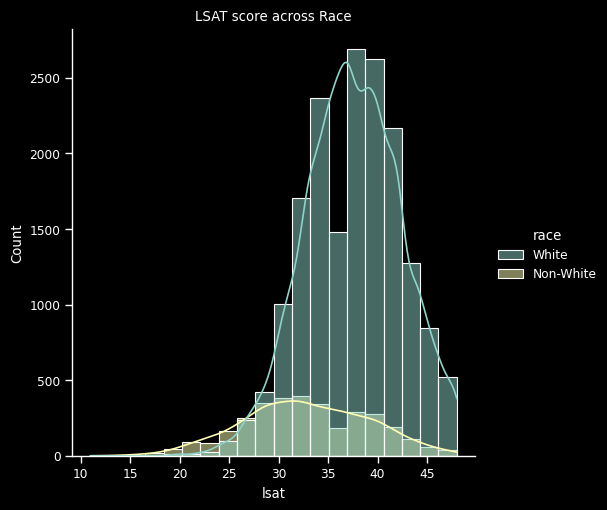

In [14]:
# plot distribution of lsat scores across races
var = 'lsat'
sns.displot(data=data_df, x=var, hue='race', kde=True, bins=20)
plt.title(f'{var.upper()} score across Race')
plt.show()

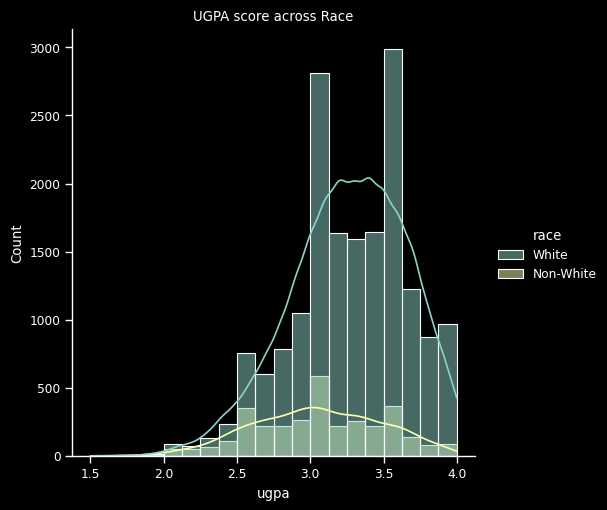

In [15]:
# plot distribution of lsat scores across races
var = 'ugpa'
sns.displot(data=data_df, x=var, hue='race', kde=True, bins=20)
plt.title(f'{var.upper()} score across Race')
plt.show()

## Pre-processing

In [16]:
## Training Test Split
train_df = data_df.sample(frac=0.8, random_state=42)
test_df = data_df.drop(train_df.index)

In [17]:
test_white_idx = test_df['race']=='White'
test_nw_idx = test_df['race']!='White'

In [18]:
# standardize numerical features
for feature in numerical_features:
    scaler = StandardScaler()
    train_df[feature] = scaler.fit_transform(train_df[feature].values.reshape(-1,1))
    test_df[feature] = scaler.transform(test_df[feature].values.reshape(-1,1))

In [19]:
# one-hot encode categorical features
for feature in categorical_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [20]:
# one hot encode binary features
for feature in binary_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [21]:
test_white_df = test_df[test_white_idx]
test_nw_df = test_df[test_nw_idx]

## Models

### Logistic Regression

In [22]:
# create logistic regression instance
lreg = LogisticRegression(penalty='l2')

# fit model
lreg.fit(train_df.drop('pass_bar', axis=1), train_df['pass_bar'])

# get predictions on test set
lreg_y_pred = lreg.predict(test_df.drop('pass_bar', axis=1))
lreg_y_proba = lreg.predict_proba(test_df.drop('pass_bar', axis=1))

lreg_w_y_pred = lreg.predict(test_white_df.drop('pass_bar', axis=1))
lreg_nw_y_pred = lreg.predict(test_nw_df.drop('pass_bar', axis=1))

# get confusion matrix
lreg_confusion_matrix = confusion_matrix(test_df['pass_bar'], lreg_y_pred)
lreg_w_confusion_matrix = confusion_matrix(test_white_df['pass_bar'], lreg_w_y_pred)
lreg_nw_confusion_matrix = confusion_matrix(test_nw_df['pass_bar'], lreg_nw_y_pred)

### Random Forest

In [23]:
rforest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# fit model
rforest.fit(train_df.drop('pass_bar', axis=1), train_df['pass_bar'])

# get predictions on test set
rforest_y_pred = rforest.predict(test_df.drop('pass_bar', axis=1))
rforest_y_proba = rforest.predict_proba(test_df.drop('pass_bar', axis=1))

rforest_w_y_pred = rforest.predict(test_white_df.drop('pass_bar', axis=1))
rforest_nw_y_pred = rforest.predict(test_nw_df.drop('pass_bar', axis=1))

# get confusion matrix
rforest_confusion_matrix = confusion_matrix(test_df['pass_bar'], rforest_y_pred)
rforest_w_confusion_matrix = confusion_matrix(test_white_df['pass_bar'], rforest_w_y_pred)
rforest_nw_confusion_matrix = confusion_matrix(test_nw_df['pass_bar'], rforest_nw_y_pred)

## Metrics

In [24]:
def compute_metrics(c_matrices, np_group='White', p_group='Non-White'):
    accuracies = {}

    for model in c_matrices.keys():
        accuracies[model] = {}
        for group in c_matrices[model].keys():
            accuracies[model][group] = compute_accuracy(c_matrices[model][group])
            print(f'{model} {group} accuracy: {accuracies[model][group]}')
    print('\n')

    # tpr 
    tprs = {}

    for model in c_matrices.keys():
        tprs[model] = {}
        for group in c_matrices[model].keys():
            tprs[model][group] = compute_true_positive_rate(c_matrices[model][group])
            print(f'{model} {group} TPR: {tprs[model][group]}')
    print('\n')
    
    # tnr
    tnrs = {}

    for model in c_matrices.keys():
        tnrs[model] = {}
        for group in c_matrices[model].keys():
            tnrs[model][group] = compute_true_negative_rate(c_matrices[model][group])
            print(f'{model} {group} TNR: {tnrs[model][group]}')
    print('\n')

    # statistical parity
    statistical_parity = {}

    for model in c_matrices.keys():
        statistical_parity[model] = compute_statistical_parity(c_matrices[model][np_group], c_matrices[model][p_group])
        print(f'{model} statistical parity: {statistical_parity[model]}')
    print('\n')

    # equalized odds
    equalized_odds = {}

    for model in c_matrices.keys():
        equalized_odds[model] = compute_equalized_odds(c_matrices[model][np_group], c_matrices[model][p_group])
        print(f'{model} equalized odds: {equalized_odds[model]}')
    print('\n')

In [25]:
c_matrices = {
    'Logistic Regression': {
        'All': lreg_confusion_matrix,
        'White': lreg_w_confusion_matrix,
        'Non-White': lreg_nw_confusion_matrix,
    },
    'Random Forest': {
        'All': rforest_confusion_matrix,
        'White': rforest_w_confusion_matrix,
        'Non-White': rforest_nw_confusion_matrix,
    }
}


In [26]:
compute_metrics(c_matrices)

Logistic Regression All accuracy: 0.8927884615384616
Logistic Regression White accuracy: 0.9190751445086706
Logistic Regression Non-White accuracy: 0.7628571428571429
Random Forest All accuracy: 0.8918269230769231
Random Forest White accuracy: 0.9173410404624277
Random Forest Non-White accuracy: 0.7657142857142857


Logistic Regression All TPR: 0.9761452968284088
Logistic Regression White TPR: 0.9889971707010374
Logistic Regression Non-White TPR: 0.8956692913385826
Random Forest All TPR: 0.9788560585524533
Random Forest White TPR: 0.9908833700094309
Random Forest Non-White TPR: 0.9035433070866141


Logistic Regression All TNR: 0.23991507430997877
Logistic Regression White TNR: 0.12186379928315412
Logistic Regression Non-White TNR: 0.4114583333333333
Random Forest All TNR: 0.21019108280254778
Random Forest White TNR: 0.07885304659498207
Random Forest Non-White TNR: 0.4010416666666667


Logistic Regression statistical parity: 0.09332787936245479
Random Forest statistical parity: 0.087340

In [27]:
# computing abroca 
## adding prediction column to test dataframes
# copy test_df
test_df['lreg_proba'] = lreg_y_proba[:,1]
test_df['rforest_proba'] = rforest_y_proba[:,1]

# map pass_bar to 1 and 0
test_df['pass_bar'] = test_df['pass_bar'].map({1.0: 1, 0.0: 0})

## map race_White to white and non-white
test_df['race_White'] = test_df['race_White'].map({1.0: 'White', 0.0: 'Non-White'})

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


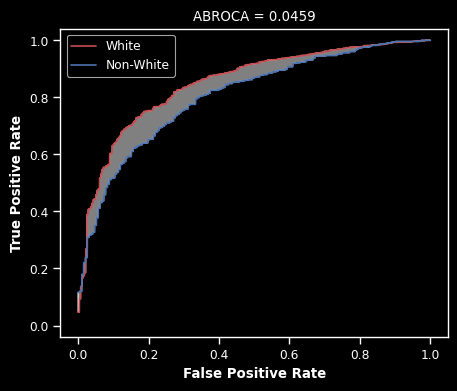

In [28]:
compute_abroca(
    test_df, 
    pred_col='lreg_proba', 
    label_col='pass_bar', 
    p_attr_col='race_White', 
    np_p_attr_val='White', 
    plot_slices=True,
    np_group_name = 'White',
    p_group_name = 'Non-White')

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


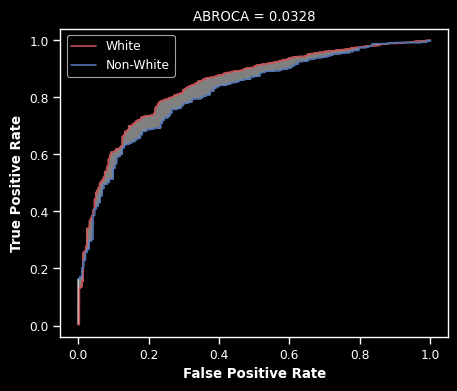

In [29]:
compute_abroca(
    test_df, 
    pred_col='rforest_proba', 
    label_col='pass_bar', 
    p_attr_col='race_White', 
    np_p_attr_val='White', 
    plot_slices=True,
    np_group_name = 'White',
    p_group_name = 'Non-White')

## ANALYSIS

### Discrimination Assestment

- Accuracies of both models are similar.
- Both models demonstrate better prediction performance for non-protected groups.
- True positive rates (TPR) are similar between the models but lower for protected groups.
- True negative rates (TNR) are lower for both models compared to TPR.
- There is a significant disparity in TNR between non-protected and protected groups, with the non-protected group having a lower TNR.
- Both models more frequently predict the protected group as not successful.
- Imbalance in class distribution significantly impacts model performance.
- Logistic regression is considered less fair than random forest based on group parity and ABROCA fairness metrics.
- Equalized odds metric suggests the opposite, likely due to the models relying on the positive class and resulting in lower TNR.
- Equalized odds highlights the disparity in TNR compared to other metrics in this case.

<!---
The accuracies of both models are nearly identical. However, they demonstrate significantly better prediction for non-protected groups. Looking at the true positive rate (TPR), both models have similar figures, although they exhibit lower scores in the case of protected groups. In terms of the true negative rate (TNR), both models have lower scores compared to TPR. More importantly, both models show a considerable disparity between non-protected and protected groups, with the non-protected group having a lower TNR. This also means that both models predict the protected group to be classified as not successful more often.

This confirms that an imbalance in class distribution has a significant impact on model performance. In this particular case, both models relied more heavily on the positive class. Additionally, the proportion of the positive class in the non-protected group is smaller. This can lead to the development of unfair models.

Comparing fairness metrics, both group parity and ABROCA indicate that logistic regression is less fair than random forest. However, the equalized odds metric suggests the opposite. This difference could be due to the nature of these fairness measures. Group parity is based on positive predicted outcomes only, while ABROCA is based on prediction error, which measures disparity between different groups. Equalized odds, on the other hand, takes both TPR and TNR into account and measures the disparity of those across different groups. As mentioned earlier, the models tend to rely on the positive class, thus yielding lower TNR. Therefore, in this case, equalized odds highlights the disparity of TNR compared to the other metrics.
-->

### Possible Mitigation

Both models appear to have low true negative rates (TNR), indicating that they were optimized to predict positive classes. Collecting more data might be necessary to improve the performance of the models.
Another option is to resample the data to balance the class distribution. This can be done by either undersampling the majority class or oversampling the minority class.
Furthermor, choosing different threshold for each group might be useful.


# CREDIT DATASET

In [30]:
data_path = 'data/Homework3_dataset_credit.csv'
data_df = pd.read_csv(data_path)

data_df.head()

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,other-debtors,residence-since,...,other-installment,housing,existing-credits,job,number-maintenance,telephone,foreign-worker,sex,marital-status,class-label
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,none,4,...,none,own,2,skilled employee / official,1,yes,yes,male,divorced/separated,1
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,none,2,...,none,own,1,skilled employee / official,1,none,yes,female,divorced/separated,0
2,no account,12,critical account,education,2096,<100 DM,4<= <7 years,2,none,3,...,none,own,1,unskilled - resident,2,none,yes,male,divorced/separated,1
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,guarantor,4,...,none,for free,1,skilled employee / official,2,none,yes,male,divorced/separated,1
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,none,4,...,none,for free,2,skilled employee / official,2,none,yes,male,divorced/separated,0


In [31]:
# adding age older than 25 column
data_df["older"] = data_df["age"] > 25

In [32]:
# dictionry of types of data
numerical_features = {
    'duration',
    'credit-amount',
    'installment-rate',
    'residence-since',
    'age',
    'existing-credits',
    'number-maintenance',
     }

binary_features = {
    'telephone',
    'foreign-worker',
    'older',
    }

categorical_features = {
    'checking-account',
    'credit-history',
    'purpose',
    'savings-account',
    'employment-since',
    'other-debtors',
    'property',
    'other-installment',
    'housing',
    'job',
    'sex',
    'marital-status',
    }

## Data Visualization

In [33]:
# compate number of olders and youngers
older_df = data_df[data_df['older'] == True]
n_older = older_df.shape[0]
print(f'total older data: {n_older}')

younger_df = data_df[data_df['older'] == False]
n_younger = younger_df.shape[0]
print(f'total younger data: {n_younger}')


total older data: 810
total younger data: 190


In [34]:
n_passed_old = older_df[older_df['class-label'] == 1.0].shape[0]
n_passed_young = younger_df[younger_df['class-label'] == 1.0].shape[0]

print(f'older acceptance number: {n_passed_old}')
print(f'younger acceptance number: {n_passed_young}')

older acceptance number: 590
younger acceptance number: 110


In [35]:
print(f'all acceptance rate: {(n_passed_old + n_passed_young) / (n_older + n_younger)}')
print(f'older acceptance rate: {n_passed_old / n_older}')
print(f'younger acceptance rate: {n_passed_young / n_younger}')

all acceptance rate: 0.7
older acceptance rate: 0.7283950617283951
younger acceptance rate: 0.5789473684210527


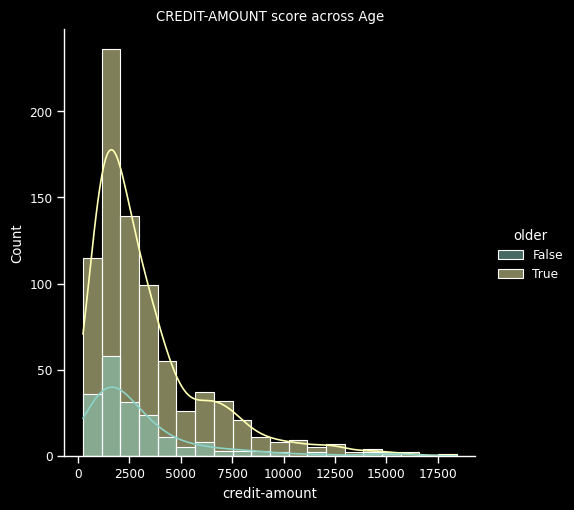

In [36]:
# plot distribution of lsat scores across races
var = 'credit-amount'
sns.displot(data=data_df, x=var, hue='older', kde=True, bins=20)
plt.title(f'{var.upper()} score across Age')
plt.show()

## Pre-processing

In [37]:
## Training Test Split
train_df = data_df.sample(frac=0.8, random_state=42)
test_df = data_df.drop(train_df.index)

In [38]:
older_idx = test_df['older'] == True
younger_idx = test_df['older'] == False

In [39]:
# standardize numerical features
for feature in numerical_features:
    scaler = StandardScaler()
    train_df[feature] = scaler.fit_transform(train_df[feature].values.reshape(-1,1))
    test_df[feature] = scaler.transform(test_df[feature].values.reshape(-1,1))

In [40]:
# one-hot encode categorical features
for feature in categorical_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [41]:
train_df.head()

,duration,credit-amount,installment-rate,residence-since,age,existing-credits,number-maintenance,telephone,foreign-worker,class-label,...,purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_others,purpose_radio/television,purpose_repairs,purpose_retraining
521,-0.248354,-0.033686,-0.854740,-0.771088,-1.016476,-0.695132,-0.438464,none,yes,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
737,-0.248354,0.392868,0.034456,1.029993,-0.057125,-0.695132,2.280691,yes,yes,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,0.239013,-0.343744,-0.854740,0.129453,-0.318766,-0.695132,-0.438464,none,yes,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
660,-0.735722,-0.712229,0.034456,1.029993,-1.103690,-0.695132,-0.438464,none,yes,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
411,0.970064,1.422691,0.034456,-0.771088,-0.057125,1.053628,-0.438464,yes,yes,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# one hot encode binary features
for feature in binary_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [43]:
test_older_df = test_df[older_idx]
test_younger_df = test_df[younger_idx]

## Models

### Logistic Regression

In [44]:
target_label = 'class-label'
# create logistic regression instance
lreg = LogisticRegression(penalty='l2')

# fit model
lreg.fit(train_df.drop(target_label, axis=1), train_df[target_label])

# get predictions on test set
lreg_y_pred = lreg.predict(test_df.drop(target_label, axis=1))
lreg_y_proba = lreg.predict_proba(test_df.drop(target_label, axis=1))

lreg_w_y_pred = lreg.predict(test_older_df.drop(target_label, axis=1))
lreg_nw_y_pred = lreg.predict(test_younger_df.drop(target_label, axis=1))

# get confusion matrix
lreg_confusion_matrix = confusion_matrix(test_df[target_label], lreg_y_pred)
lreg_w_confusion_matrix = confusion_matrix(test_older_df[target_label], lreg_w_y_pred)
lreg_nw_confusion_matrix = confusion_matrix(test_younger_df[target_label], lreg_nw_y_pred)

## Random Forest

In [45]:
rforest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# fit model
rforest.fit(train_df.drop(target_label, axis=1), train_df[target_label])

# get predictions on test set
rforest_y_pred = rforest.predict(test_df.drop(target_label, axis=1))
rforest_y_proba = rforest.predict_proba(test_df.drop(target_label, axis=1))

rforest_w_y_pred = rforest.predict(test_older_df.drop(target_label, axis=1))
rforest_nw_y_pred = rforest.predict(test_younger_df.drop(target_label, axis=1))

# get confusion matrix
rforest_confusion_matrix = confusion_matrix(test_df[target_label], rforest_y_pred)
rforest_w_confusion_matrix = confusion_matrix(test_older_df[target_label], rforest_w_y_pred)
rforest_nw_confusion_matrix = confusion_matrix(test_younger_df[target_label], rforest_nw_y_pred)

## Metrics

In [46]:
c_matrices = {
    'Logistic Regression': {
        'All': lreg_confusion_matrix,
        'Older': lreg_w_confusion_matrix,
        'Younger': lreg_nw_confusion_matrix,
    },
    'Random Forest': {
        'All': rforest_confusion_matrix,
        'Older': rforest_w_confusion_matrix,
        'Younger': rforest_nw_confusion_matrix,
    }
}
compute_metrics(c_matrices, np_group='Older', p_group='Younger')


Logistic Regression All accuracy: 0.745
Logistic Regression Older accuracy: 0.7531645569620253
Logistic Regression Younger accuracy: 0.7142857142857143
Random Forest All accuracy: 0.79
Random Forest Older accuracy: 0.8227848101265823
Random Forest Younger accuracy: 0.6666666666666666


Logistic Regression All TPR: 0.8571428571428571
Logistic Regression Older TPR: 0.85
Logistic Regression Younger TPR: 0.9
Random Forest All TPR: 0.95
Random Forest Older TPR: 0.95
Random Forest Younger TPR: 0.95


Logistic Regression All TNR: 0.48333333333333334
Logistic Regression Older TNR: 0.4473684210526316
Logistic Regression Younger TNR: 0.5454545454545454
Random Forest All TNR: 0.4166666666666667
Random Forest Older TNR: 0.42105263157894735
Random Forest Younger TNR: 0.4090909090909091


Logistic Regression statistical parity: -0.050000000000000044
Random Forest statistical parity: 0.0


Logistic Regression equalized odds: 0.14808612440191388
Random Forest equalized odds: 0.011961722488038229




In [47]:
# computing abroca 
test_df_abroca = test_df.copy()

test_df_abroca['lreg_proba'] = lreg_y_proba[:,1]
test_df_abroca['rforest_proba'] = rforest_y_proba[:,1]

# map pass_bar to 1 and 0
test_df_abroca[target_label] = test_df_abroca[target_label].map({1.0: 1, 0.0: 0})

## map race_White to white and non-white
test_df_abroca['older_True'] = test_df_abroca['older_True'].map({1.0: 'Older', 0.0: 'Younger'})

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


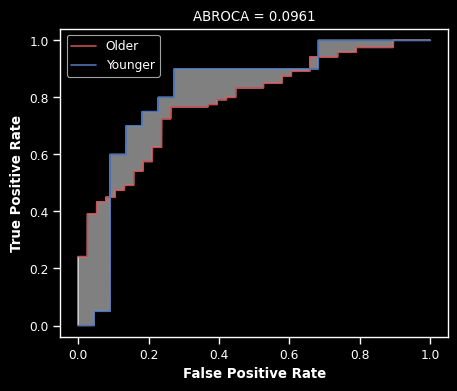

In [48]:
compute_abroca(
    test_df_abroca, 
    pred_col='lreg_proba', 
    label_col=target_label, 
    p_attr_col='older_True', 
    np_p_attr_val='Older', 
    plot_slices=True,
    np_group_name = 'Older',
    p_group_name = 'Younger')

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


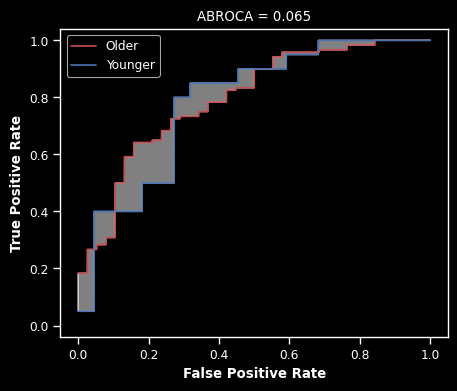

In [49]:
compute_abroca(
    test_df_abroca, 
    pred_col='rforest_proba', 
    label_col=target_label, 
    p_attr_col='older_True', 
    np_p_attr_val='Older', 
    plot_slices=True,
    np_group_name = 'Older',
    p_group_name = 'Younger')

## ANALYSIS
### Discrimination 
- Random Forest outperformed Logistic Regression in accuracy overall.
- Logistic Regression performed better for the older group, while Random Forest achieved higher accuracies for both older and younger groups.
- Random Forest had better performance in predicting the positive class, especially for the younger group, while Logistic Regression performed better in predicting negative classes.
- Both models faced class imbalance issues, with disparities between true positive and true negative rates.
- The models performed better with younger data, which had a more balanced class distribution.
- Random Forest was slightly fairer than Logistic Regression based on fairness metrics.
- Both models showed similar fairness performance in terms of statistical parity and ABROCA.
- Despite some data imbalances, both models exhibited the same level of fairness, likely due to balanced positive and negative classes within each group.
<!---
In terms of accuracy, Random Forest slightly outperformed Logistic Regression overall. However, when considering different age groups, Logistic Regression performed better for the older group with an accuracy of 0.753, whereas its accuracy was lower for the younger group at 0.714. In contrast, Random Forest achieved higher accuracies for both the older group (0.823) and the younger group (0.738).

When looking at TPR (true positive rate), Random Forest predicts the positive class better, particularly for the younger group, while Logistic Regression performs better in predicting negative classes with the TNR (true negative rate) metric.

Both models generally face issues with class imbalances, which is indicated by the disparity between true positive rate (TPR) and true negative rate (TNR). Additionally, the models performed better with younger data, which could be explained by the more balanced class distribution compared to older data.

Looking at the fairness metrics, statistical parity indicates that both models performed similarly, but random forest appeared to be a little bit fairer compared to logistic regression. The equalized odds metrics also support this finding. ABROCA scores showed little difference between the two models although not significant. Therefore, despite some imbalances in the data, both models exhibit the same level of fairness, in contrast to the metrics from the Law dataset. This could be attributed to the more balanced positive and negative classes for each group.
-->

### Possible Mitigation

Looking at the ABROCA curve, there are some thresholds that can be used to improve the fairness of the models. If one were to choose same threshold for both classes, point of intersection of the ROC curve could be a choice, since it would be the point where the models have the same true positive and true negative rates

# Comments
#### On Fairness Metric Value Range
Group parity is computed by comparing the TPR across different groups, resulting in a range of values from 1 to -1. Equalized odds sums up the differences of both TPR and NPR across groups; however, due to the absolute operator, the value can range between 0 and 2. ABROCA, on the other hand, measures the absolute difference between the AUROC of the protected and non-protected group, resulting in values ranging from 0 to 1.
####  On The Balance of Class Distribution
The Law dataset exhibits significant class imbalances, with a higher percentage of positive-labeled data (88%). Notably, the non-protected group is disproportionately affected, with 92% of its data being labeled as positive.
As for the credit dataset, the imbalance is less pronounced, with 70% of the data being labeled as positive. There is some disparity between protected and non-protected groups, with the non-protected group having a higher percentage of positive-labeled data (72%).

#### On Advantages and Disadvantages of Fairness Metrics
Group parity is the simplest approach and easier to interpret. However, since the metric only uses TPR and relies solely on predicted outcomes, it may not capture disparities on negative outcomes.

Equalized odds, on the other hand, attempts to equalize both TPR and TNR. This may be more explanatory compared to group parity. However, including TNR would make the values harder to analyze since disparities can now arise from both sides.

ABROCA measures the differences in AUROC between different groups. This approach tends to be more versatile since it removes the requirement of choosing a certain threshold. However, computing ABROCA is more complicated.
#### On The Consistency Level of Fairness Metrics
It is difficult to compare the consistency of fairness metrics because they use different measurements. However, differences can be seen in the value range of the metrics. Equalized odds tends to have a larger value compared to others, but the scale of the value does not indicate consistency. Therefore, it is important to consider before applying fairness.
#### On Predictive Performance and Fairness Measures across Datasets
Overall, both models perform better on the law dataset compared to the credit dataset. However, this could be due to the fact that the first dataset is relatively more imbalanced. As a result, both models disproportionately use positive-labeled data. As a result of this, fairness is relatively better for the second dataset since the balance is more pronounced.